# Using Monocular Depth Estimation to Mask an Image

- Or, How I Selected a Dinosaur and Isolated It Out of a Flat Image

## What the code does - in pictures!
![image/MonocularDepthEstimation3examples.png](image/MonocularDepthEstimation3examples.png)

In [1]:
# !source /opt/intel/oneapi/setvars.sh #comment out if not running on Intel Developer Cloud Jupyter
# !pip install transformers==4.34.1
# !pip install intel_extension_for_transformers==1.2.2
# !pip install intel_extension_for_pytorch==2.1.100
# !pip install tqdm
# !pip install einops
# !pip install neural_speed==0.2
# !pip install torch==2.1.1

# Background

In this article I will guide you through the steps I took to create a clipped image with background clutter removed from the image. I will accomplish this using Monocular Depth Estimation. This could potentially be used to automate structure from motion and other image related tasks where you want to highlight or focus on a single portion of an image, particularly for identifying parts of the image that were closest to the camera when taken. 

## Monocular Depth Estimation

Monocular Depth Estimation (DPT), aiming to infer detailed depth from a single image or camera view, finds applications in fields like generative AI, 3D reconstruction, and autonomous driving. However, deriving depth from individual pixels in a single image is challenging due to the underconstrained nature of the problem. Recent advancements attribute progress to learning-based methods, particularly with MiDaS, leveraging dataset mixing and scale-and-shift-invariant loss. 

## MiDaS

## (Multiple Depth Estimation Accuracy with Single Network)

MiDaS computes relative inverse depth from a single image. The repository provides multiple models that cover different use cases ranging from a small, high-speed model to a very large model that provide the highest accuracy.

MiDaS has evolved with releases featuring more powerful backbones and lightweight variants for mobile use. With the rise of transformer architectures in computer vision, including those pioneered by models like ViT, there's been a shift towards using them for depth estimation. Inspired by this, MiDaS v3.1 incorporates promising transformer-based encoders alongside traditional convolutional ones, aiming for a comprehensive investigation of depth estimation techniques. The paper focuses on describing the integration of these backbones into MiDaS, providing a thorough comparison of different v3.1 models, and offering guidance on utilizing future backbones with MiDaS. This DPT model uses the Hugging Face BEiT model as backbone and adds a neck + head on top for monocular depth estimation and was created by Intel. 

## This specific model is MiDaS: dpt-beit-large-512

It is called dpt-beit-large-512 (but we have more compact resolutions as well). This model is based on a resolution of 512x512 internally, but images of any size can be inferred against this model. For more information about this model – see a condensed explanation on Hugging Face Model Card, dpt-beit-large-512 or a deeper dive explanation in this paper “MiDaS v3.1 – A Model Zoo for Robust Monocular Relative Depth Estimation” by Reiner Birkl, Diana Wofk, Matthias Muller.

## Attribution:
“MiDaS v3.1 – A Model Zoo for Robust Monocular Relative Depth Estimation” by **Reiner Birkl, Diana Wofk, Matthias Muller.**

## Huggingface model card:

the Huggingface **[model card](https://huggingface.co/Intel/dpt-beit-large-512)** will detail more information and different examples for you to try and realted more compact models such as **[dpt-beit-large-384](https://huggingface.co/Intel/dpt-beit-large-384)** are also available.

# Youtube Videos:
- [MiDaS Depth Estimation | Intel Technology](https://www.youtube.com/watch?v=UjaeNNFf9sE)
- [[CVPR 2024] Language Model Assisted Generation of Images with Coherence by Intel Labs/Cai Zhipeng](https://www.youtube.com/watch?v=XDMNEzH4-Ec)
- [AI Depth Map Single Camera with MiDaS by Kevin Woods | Robotics](https://www.youtube.com/watch?v=UUzpepJ_mLk)

In [2]:
import torch
print(torch.__version__)
import transformers
print(transformers.__version__)


from transformers import DPTImageProcessor, DPTForDepthEstimation
import torch
import numpy as np
from PIL import Image
import requests



2.1.0.post0+cxx11.abi
4.39.3


# From this image - 3D dinosaur with painted mural wall in background:

RGB


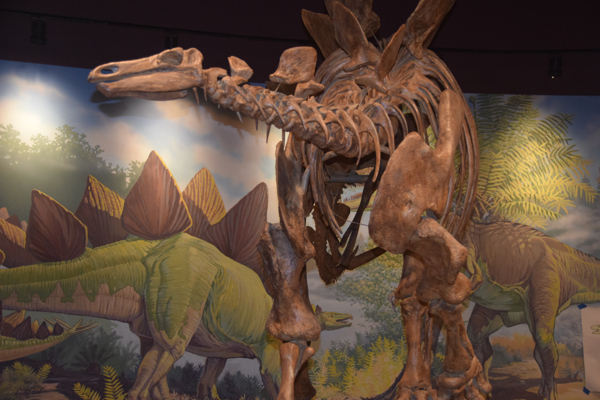

In [3]:
#path = "image/D71_1620.png" # Stegosasurus
path = "image/DSC_0566.png" # Stegosasurus

#path = "image/Pottery_20231001_135018.jpg" #Pottery
image = Image.open(path)
MAX_SIZE = (600, 400) 
  
image.thumbnail(MAX_SIZE) 
print(image.mode)
image


# to this image - 3D dinosaur with mural removed:¶

![image/DinoWithMuralBackgroundClipped.png](image/DinoWithMuralBackgroundClipped.png)

In [6]:
processor = DPTImageProcessor.from_pretrained("Intel/dpt-beit-large-512")
model = DPTForDepthEstimation.from_pretrained("Intel/dpt-beit-large-512")

Elapsed 3.27


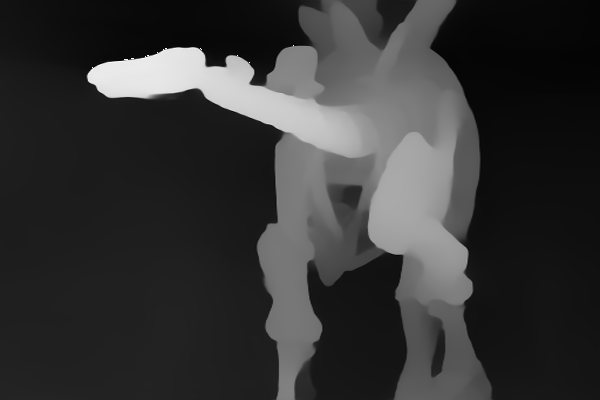

In [7]:
import time
start = time.time()
# prepare image for the model
inputs = processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

# interpolate to original size
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
)
# prepare image for the model
inputs = processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

# interpolate to original size
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
)
print( f"Elapsed {(time.time() - start):.2f}" )
# visualize the prediction
output = prediction.squeeze().cpu().numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)
depth

# Create a clipping mask

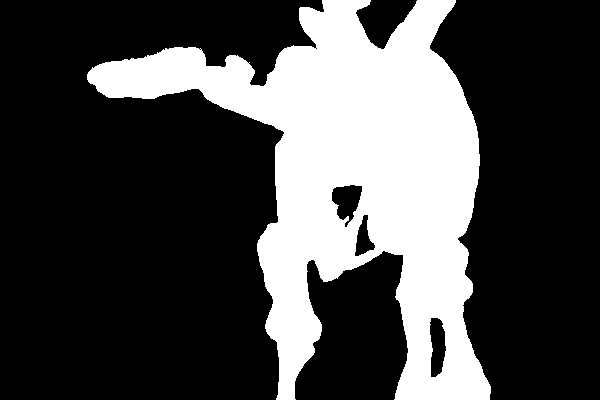

In [8]:
Threshold = 66 # use 155 for Pottery
a = np.array(depth)
b = np.where(a>Threshold,a,0)
b[b>Threshold] = 255
mask = Image.fromarray(b).convert('L')
black = Image.fromarray(a*0).convert('L')
mask.convert('RGB').show()

# Clip original image

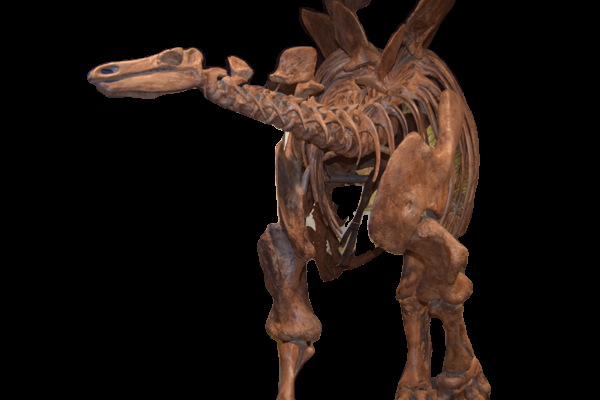

In [9]:
out = Image.composite(image.convert('RGB'), black.convert('RGB'), mask.convert('1'))
out.convert('RGB').show()

# Pottery Example

RGB


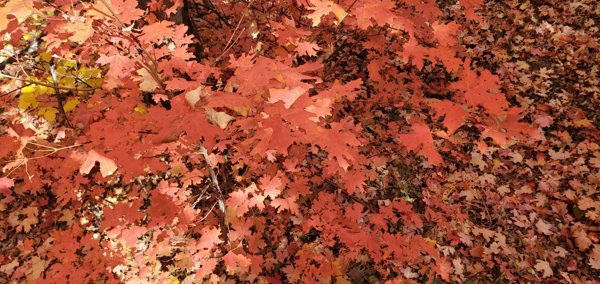

In [10]:
#path = "image/Pottery_20231001_135018.jpg" #Pottery
path = "image/Autumn_NM2_20231021_152718.jpg"
#image = Image.open(path)
image = Image.open(path).convert("RGB")
MAX_SIZE = (600, 400) 
  
image.thumbnail(MAX_SIZE) 
print(image.mode)
image

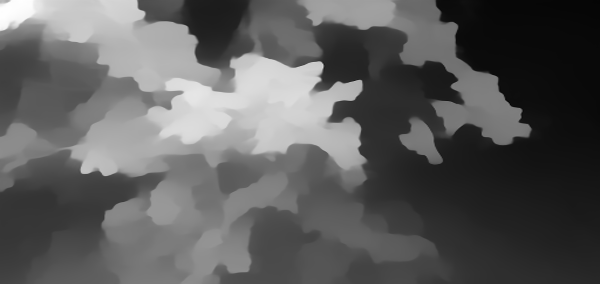

In [11]:
# prepare image for the model

inputs = processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

# interpolate to original size
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
)
# prepare image for the model
inputs = processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

# interpolate to original size
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

# visualize the prediction
output = prediction.squeeze().cpu().numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)
depth

# Clip mask & clipped result

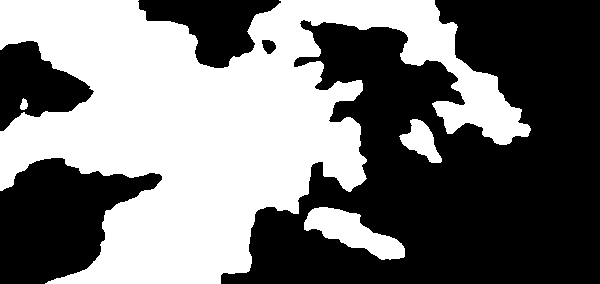

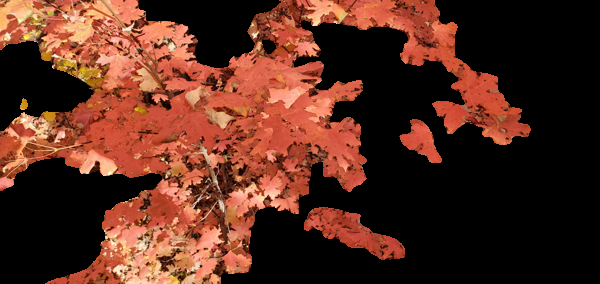

In [12]:
Threshold = 90 # use 155 for Pottery
a = np.array(depth)
b = np.where(a>Threshold,a,0) # if depth is above a certain threshold of white put bool in b
b[b>=Threshold] = 255 #set above threshold to white 255
mask = Image.fromarray(b).convert('L')
black = Image.fromarray(a*0).convert('L')
mask.convert('RGB').show()
out = Image.composite(image.convert('RGB'), black.convert('RGB'), mask.convert('1'))
out.convert('RGB').show()

# Summary

I demonstrated that how to use Depth Estimation to create an easy masking technique to hide visual clutter from a background image. In one example, I demonstrated a picture from a museum with a background mural and a 3D dinosaur cast in front of the mural. The Intel/dpt-beit-large-512 DPT model as able to pull the dinosaur out of the noisy background.

# Play with these concepts on the Intel(r) Tiber(tm) Developer Cloud:
Take the opportunity to play with Monocular Depth Estimati. For a sandbox to play in — register for a free account on the **[Intel Tiber Developer Cloud](cloud.intel.com)**, sign in and play by clicking on the icon in the lower left

Then Launch JupyterLab on the shared access node in the icon on the right

# Code
The code for this article and the rest of the series is located on **[github](https://github.com/zmadscientist/DinosaurDepthMapClipping)**. For this article experiment with the file: dpt_dino.ipynb Intel Developer Cloud System Configuration as tested:

# Machine Details:
- x86_64
- CPU op-mode(s): 32-bit, 64-bit
- Address sizes: 52 bits physical, 57 bits virtual
- Byte Order: Little Endian
- CPU(s): 224
- On-line CPU(s) list: 0–223
- Vendor ID: GenuineIntel
- Model name: Intel(R) Xeon(R) Platinum 8480+
- CPU family: 6
- Model: 143
- Thread(s) per core: 2
- Core(s) per socket: 56
- Socket(s): 2
- Stepping: 8
- CPU max MHz: 3800.0000
- CPU min MHz: 800.0000